## Visualize Screen Metadata

Each screen is a unique experiment. Visualize the diversity of experimental details in IDR screens.

**Note:** This notebook is WIP

In [1]:
import pathlib
import re
import pandas as pd
import plotnine as gg

In [2]:
data_dir = pathlib.Path("data")

## Load data

In [3]:
# Load IDR ids
id_file = pathlib.Path(data_dir, "idr_ids.tsv")

id_df = pd.read_csv(id_file, sep="\t")

print(id_df.shape)
id_df.head(2)

(198, 5)


,id,name,title,description,category
0,3,idr0001-graml-sysgro/screenA,A genomic Multiprocess survey of machineries t...,Primary screen of fission yeast knock out muta...,Screen
1,102,idr0002-heriche-condensation/screenA,Integration of biological data by kernels on g...,Screen of 100 candidate genes predicted to be ...,Screen


In [4]:
# Load screen details
screen_file = pathlib.Path(data_dir, "screen_details.tsv")
screen_df = pd.read_csv(screen_file, sep="\t")

print(screen_df.shape)
screen_df.head(2)

(80, 24)


,Sample Type,Organism,Study Type,Screen Type,Screen Technology Type,Imaging Method,Publication Title,Publication Authors,PubMed ID,PMC ID,...,External URL,Annotation File,internal_id,upload_date,idr_name,screen_id,Study Title,Data Publisher,Data DOI,BioStudies Accession
0,cell,Schizosaccharomyces pombe,high content screen,primary screen,gene deletion screen,spinning disk confocal microscopy,A genomic Multiprocess survey of machineries t...,"Graml V, Studera X, Lawson JLD, Chessel A, Gey...",25373780 https://www.ncbi.nlm.nih.gov/pubmed/2...,PMC4648281 https://www.ncbi.nlm.nih.gov/pmc/ar...,...,www.sysgro.org,idr0001-screenA-annotation.csv https://github....,20516150,2019-06-04T10:43:11+01:00,idr0001-graml-sysgro/screenA,3,NaN,NaN,NaN,NaN
1,cell,Homo sapiens,high content screen,primary screen,RNAi screen,fluorescence microscopy,Integration of biological data by kernels on g...,"Hériché JK, Lees JG, Morilla I, Walter T, Petr...",24943848 https://www.ncbi.nlm.nih.gov/pubmed/2...,PMC4142622 https://www.ncbi.nlm.nih.gov/pmc/ar...,...,NaN,idr0002-screenA-annotation.csv https://github....,20516151,2019-06-04T10:43:19+01:00,idr0002-heriche-condensation/screenA,102,Focused mitotic chromsome condensaton screen u...,NaN,NaN,NaN


In [5]:
# Load all plates
plate_file = pathlib.Path(data_dir, "plate_details_per_screen.tsv")

plate_df = pd.read_csv(plate_file, sep="\t").merge(screen_df, on="screen_id", how="left")
plate_df.n_wells = plate_df.n_wells.astype(str)

print(plate_df.shape)
plate_df.head(2)

(5217, 31)


,screen_id,plate_id,plate_name,n_wells,cell_line,channels,pixel_size_x,pixel_size_y,Sample Type,Organism,...,Copyright,External URL,Annotation File,internal_id,upload_date,idr_name,Study Title,Data Publisher,Data DOI,BioStudies Accession
0,3,2551,JL_120731_S6A,96,Not listed,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,1376,1040,cell,Schizosaccharomyces pombe,...,Graml et al,www.sysgro.org,idr0001-screenA-annotation.csv https://github....,20516150,2019-06-04T10:43:11+01:00,idr0001-graml-sysgro/screenA,NaN,NaN,NaN,NaN
1,3,2552,JL_120731_S6B,96,Not listed,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,1376,1040,cell,Schizosaccharomyces pombe,...,Graml et al,www.sysgro.org,idr0001-screenA-annotation.csv https://github....,20516150,2019-06-04T10:43:11+01:00,idr0001-graml-sysgro/screenA,NaN,NaN,NaN,NaN


## Explore visualizations

The total number of wells is: 1,739,520
The mean number of plates is: 65.2125


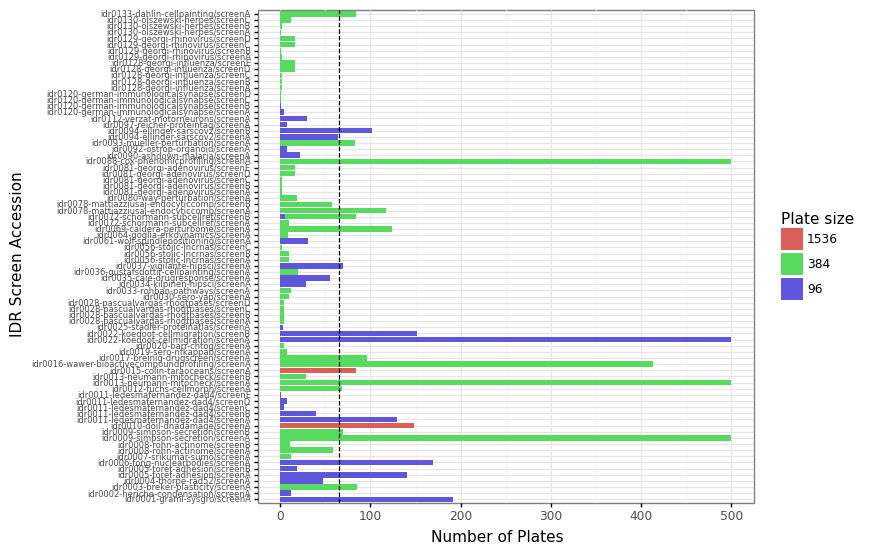

<ggplot: (325911060)>

In [6]:
# Number of wells per experiment
print(f"The total number of wells is: {plate_df.n_wells.astype(int).sum():,d}")

mean_num_plates = plate_df.groupby("idr_name")["screen_id"].count().mean()
print(f"The mean number of plates is: {mean_num_plates}")

gg.options.figure_size = (6.4, 6.4)

(
    gg.ggplot(plate_df, gg.aes(x="idr_name", fill="n_wells"))
    + gg.geom_bar()
    + gg.theme_bw()
    + gg.theme(axis_text_y=gg.element_text(size=6))
    + gg.coord_flip()
    + gg.geom_hline(yintercept=mean_num_plates, linetype="dashed")
    + gg.ylab("Number of Plates")
    + gg.xlab("IDR Screen Accession")
    + gg.scale_fill_discrete(name="Plate size")
)

In [7]:
# Channels per plate
channel_df = (
    plate_df
    .assign(
        split_channels=plate_df.channels.str.split(";")
    )
    .loc[:, ["screen_id", "plate_name", "idr_name", "channels", "split_channels"]]
    .drop_duplicates(subset=["plate_name", "screen_id"])
    .reset_index(drop=True)
)

channel_df.head()

,screen_id,plate_name,idr_name,channels,split_channels
0,3,JL_120731_S6A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:..."
1,3,JL_120731_S6B,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:..."
2,3,JL_120801_S7A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:..."
3,3,JL_120801_S7B,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:..."
4,3,JL_120802_S8A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:..."


In [8]:
channel_df.drop_duplicates("screen_id").channels.unique()

array(['GFP:endogenous alpha tubulin 2;Cascade blue:growth media',
       'H2B- mCherry/Cy3:chromatin;eGFP:nuclear lamina and report on nuclear envelope breakdown',
       'H2B-mCherry:cytosol;GFP:tagged protein;bright field/transmitted:cell',
       'DIC:cell structure;YFP:Rad52-YFP protein', 'Hoechst:DNA',
       'DAPI:nuclei;TRITC:HA_Flag tagged protein',
       'Exp1Cam1:various;Exp1Cam2:various',
       'TRITC:phallodin/F-actin;TRITC2:phallodin/F-actin;FITC:alpha-tubulin;Dapi:DNA',
       'Not listed',
       'dapi: DNA;vsvg-cfp: CFP-tsO45G ;pm-647: cell surface tsO45G',
       'Dapi/Hoechst 33258: DNA;53bp1/Alexa Fluor 488:53bp1',
       'YFP:DAD4; mRFP1:SPC42; DIC: whole cell',
       'TagYFP:DAD4; mRFP1:SPC42',
       'Alexa 488:tubulin;Hoechst:DNA;Tritc:actin',
       'GFP: core histone 2B tagged with GFP to monitor chromosomes',
       'Hoechst 33342:nucleus;concanavalin A (con A) AlexaFluor488 conjugate:endoplasmic reticulumn;SYTO 14 green fluorescent nucleic acid stain:nucl

In [9]:
test = channel_df.query("idr_name=='idr0069-caldera-perturbome/screenA'")
test

,screen_id,plate_name,idr_name,channels,split_channels
3771,2251,1315001,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]
3772,2251,1315002,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]
3773,2251,1315003,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]
3774,2251,1315004,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]
3775,2251,1315005,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]
...,...,...,...,...,...
3890,2251,1315120,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]
3891,2251,1315121,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]
3892,2251,1315122,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]
3893,2251,1315123,idr0069-caldera-perturbome/screenA,Not listed,[Not listed]


In [10]:
exclusions = [
    "ch00:",
    "ch01:",
    "ch02:",
    "exp1cam1:",
    "exp2cam2:",
    "exp3cam3:",
    "exp4cam2:"
]

def split_channel_marker(x, exclusions):
    
    remove = [x.startswith(y) for y in exclusions] 
    
    if any(remove):
        prefix_removal = dict(zip(remove, exclusions))[True]
        x = x.removeprefix(prefix_removal)
        
    return x


def convert_to_colon_notation(x):
    try:
        found = re.search(r'\(.*?\)', x).group(0)
        mark = found.strip("()")
        stain = x.replace(found, "").rstrip()
        output = f"{stain}:{mark}"
    except AttributeError:
        output = x

    return output

In [11]:
def curate_channel(group):
    
    if group[0] == "Not listed":
        return []
    
    group = [x.split(",") for x in group]
    group = [item for sublist in group for item in sublist]
    
    group = [convert_to_colon_notation(item.lstrip().lower()) for item in group]
    
    return [split_channel_marker(x, exclusions) for x in group]

In [12]:
full_df = channel_df.assign(curated_channel=[curate_channel(x) for x in channel_df.split_channels])
full_df

,screen_id,plate_name,idr_name,channels,split_channels,curated_channel
0,3,JL_120731_S6A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:..."
1,3,JL_120731_S6B,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:..."
2,3,JL_120801_S7A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:..."
3,3,JL_120801_S7B,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:..."
4,3,JL_120802_S8A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:..."
...,...,...,...,...,...,...
5210,3151,BR00114102,idr0133-dahlin-cellpainting/screenA,"Ch1 (blue): Nuclei, Ch2 (green): ER, Ch3 (yell...","[Ch1 (blue): Nuclei, Ch2 (green): ER, Ch3 (yel...","[ch1 : nuclei:blue, ch2 : er:green, ch3 : nucl..."
5211,3151,BR00114103,idr0133-dahlin-cellpainting/screenA,"Ch1 (blue): Nuclei, Ch2 (green): ER, Ch3 (yell...","[Ch1 (blue): Nuclei, Ch2 (green): ER, Ch3 (yel...","[ch1 : nuclei:blue, ch2 : er:green, ch3 : nucl..."
5212,3151,BR00114104,idr0133-dahlin-cellpainting/screenA,"Ch1 (blue): Nuclei, Ch2 (green): ER, Ch3 (yell...","[Ch1 (blue): Nuclei, Ch2 (green): ER, Ch3 (yel...","[ch1 : nuclei:blue, ch2 : er:green, ch3 : nucl..."
5213,3151,BR00114105,idr0133-dahlin-cellpainting/screenA,"Ch1 (blue): Nuclei, Ch2 (green): ER, Ch3 (yell...","[Ch1 (blue): Nuclei, Ch2 (green): ER, Ch3 (yel...","[ch1 : nuclei:blue, ch2 : er:green, ch3 : nucl..."


In [13]:
full_channel_list_df = full_df.curated_channel.apply(pd.Series).stack().reset_index().loc[:, ["level_0", 0]]
full_channel_list_df.columns = ["original_index", "channel"]

final_df = full_df.merge(full_channel_list_df, how="right", left_index=True, right_on="original_index")
final_df.head()

,screen_id,plate_name,idr_name,channels,split_channels,curated_channel,original_index,channel
0,3,JL_120731_S6A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:...",0,gfp:endogenous alpha tubulin 2
1,3,JL_120731_S6A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:...",0,cascade blue:growth media
2,3,JL_120731_S6B,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:...",1,gfp:endogenous alpha tubulin 2
3,3,JL_120731_S6B,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:...",1,cascade blue:growth media
4,3,JL_120801_S7A,idr0001-graml-sysgro/screenA,GFP:endogenous alpha tubulin 2;Cascade blue:gr...,"[GFP:endogenous alpha tubulin 2, Cascade blue:...","[gfp:endogenous alpha tubulin 2, cascade blue:...",2,gfp:endogenous alpha tubulin 2


In [14]:
split_up_df = final_df.channel.str.split(":").apply(pd.Series).loc[:, [0, 1]]
split_up_df.columns = ["stain", "mark"]
final_full_df = pd.concat([final_df, split_up_df], axis="columns").loc[:, ["screen_id", "plate_name", "idr_name", "channel", "stain", "mark"]]
final_full_df

,screen_id,plate_name,idr_name,channel,stain,mark
0,3,JL_120731_S6A,idr0001-graml-sysgro/screenA,gfp:endogenous alpha tubulin 2,gfp,endogenous alpha tubulin 2
1,3,JL_120731_S6A,idr0001-graml-sysgro/screenA,cascade blue:growth media,cascade blue,growth media
2,3,JL_120731_S6B,idr0001-graml-sysgro/screenA,gfp:endogenous alpha tubulin 2,gfp,endogenous alpha tubulin 2
3,3,JL_120731_S6B,idr0001-graml-sysgro/screenA,cascade blue:growth media,cascade blue,growth media
4,3,JL_120801_S7A,idr0001-graml-sysgro/screenA,gfp:endogenous alpha tubulin 2,gfp,endogenous alpha tubulin 2
...,...,...,...,...,...,...
10641,3151,BR00114106,idr0133-dahlin-cellpainting/screenA,ch1 : nuclei:blue,ch1,nuclei
10642,3151,BR00114106,idr0133-dahlin-cellpainting/screenA,ch2 : er:green,ch2,er
10643,3151,BR00114106,idr0133-dahlin-cellpainting/screenA,ch3 : nucleoli/cytoplasmic rna:yellow,ch3,nucleoli/cytoplasmic rna
10644,3151,BR00114106,idr0133-dahlin-cellpainting/screenA,ch4 : actin/golgi/membrane:orange,ch4,actin/golgi/membrane


In [15]:
channel_count_per_screen_df = final_full_df.groupby(["screen_id", "idr_name", "channel", "stain", "mark"]).plate_name.count().reset_index()
channel_count_per_screen_df = channel_count_per_screen_df.rename(columns={"plate_name": "plate_count"}).sort_values(by=["channel", "plate_count"], ascending=[True, False]).reset_index(drop=True)
channel_count_per_screen_df

,screen_id,idr_name,channel,stain,mark,plate_count
0,2351,idr0064-goglia-erkdynamics/screenA,405:erkktr-bfp,405,erkktr-bfp,9
1,2701,idr0080-way-perturbation/screenA,488 long:nucleoli and cytoplasmic rna,488 long,nucleoli and cytoplasmic rna,18
2,1351,idr0010-doil-dnadamage/screenA,53bp1/alexa fluor 488:53bp1,53bp1/alexa fluor 488,53bp1,148
3,2351,idr0064-goglia-erkdynamics/screenA,561:h2b-rfp,561,h2b-rfp,9
4,3202,idr0120-german-immunologicalsynapse/screenA,af 488:actin,af 488,actin,4
...,...,...,...,...,...,...
194,1501,idr0011-ledesmafernandez-dad4/screenA,yfp:dad4,yfp,dad4,129
195,1551,idr0011-ledesmafernandez-dad4/screenB,yfp:dad4,yfp,dad4,39
196,1601,idr0011-ledesmafernandez-dad4/screenC,yfp:dad4,yfp,dad4,4
197,1603,idr0011-ledesmafernandez-dad4/screenE,yfp:dad4,yfp,dad4,1


In [16]:
channel_count_per_screen_df.query("idr_name=='idr0080-way-perturbation/screenA'")

,screen_id,idr_name,channel,stain,mark,plate_count
1,2701,idr0080-way-perturbation/screenA,488 long:nucleoli and cytoplasmic rna,488 long,nucleoli and cytoplasmic rna,18
36,2701,idr0080-way-perturbation/screenA,and plasma membrane ):agp,and plasma membrane ),agp,18
53,2701,idr0080-way-perturbation/screenA,concanavalin a/alexa 488:endoplasmic reticulum,concanavalin a/alexa 488,endoplasmic reticulum,18
117,2701,idr0080-way-perturbation/screenA,hoechst 33342:dna,hoechst 33342,dna,18
147,2701,idr0080-way-perturbation/screenA,mitotracker deep red/alexa 647:mitochondria,mitotracker deep red/alexa 647,mitochondria,18


In [17]:
channel_count_per_screen_df.to_csv("data/channel_count_per_screen.tsv", sep="\t", index=False)